# Predicting Tumor Growth with Linear Regression

In this notebook, we use **linear regression** to predict tumor size over time based on the synthetic data generated from our ODE models (Logistic and Gompertz). This is the first step in applying machine learning to emulate biological growth without explicitly modeling the underlying differential equations.

---

## What We’ll Do

- Export the generated data for further analysis using linear regression
- Read the given data and plot the data using ```matplotlib.pyplot``` and ```pandas```
- Model and fit our data using ```sklearn.model_selection```
- Plot our model using ```sklearn.linear_model```

       time   logistic   gompertz
0  0.000000  10.000000  10.000000
1  0.200401  10.404687  11.983164
2  0.400802  10.825574  14.257702
3  0.601202  11.263292  16.849024
4  0.801603  11.718498  19.781519


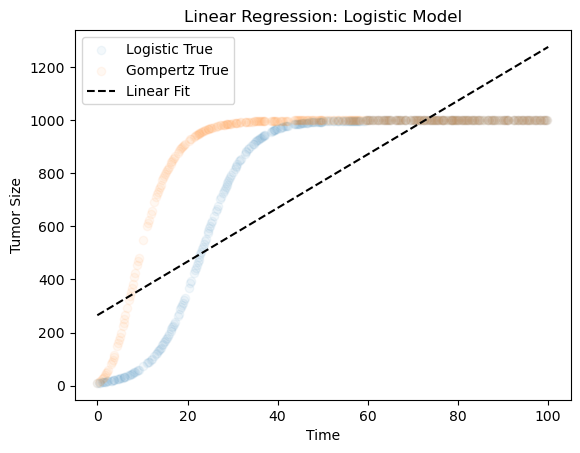

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_csv('simulated_growth_model.csv')
print(df.head())

X = df[['time']]
y_logistic = df['logistic']
y_gompertz = df['gompertz']
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_logistic, test_size=0.7, random_state=42)
X_train, X_test, y_train_gomp, y_test_gomp = train_test_split(X, y_gompertz, test_size=0.7, random_state=42)

# Model Linear Regression
model_log = LinearRegression()
model_log = LinearRegression()
model_log.fit(X_train, y_train_log)
model_gomp = LinearRegression()
model_gomp.fit(X_train, y_train_gomp)

# Plot Linear Regression results
y_pred_log = model_log.predict(X_test)
y_pred_gomp = model_log.predict(X_test)

plt.scatter(X_test, y_test_log, label='Logistic True', alpha=0.05)
plt.scatter(X_test, y_test_gomp, label='Gompertz True', alpha=0.05)
plt.plot(X, model_log.predict(X), label='Linear Fit', color='black', linestyle='--')
plt.title('Linear Regression: Logistic Model')
plt.xlabel('Time')
plt.ylabel('Tumor Size')
plt.legend()
plt.show()